In [210]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

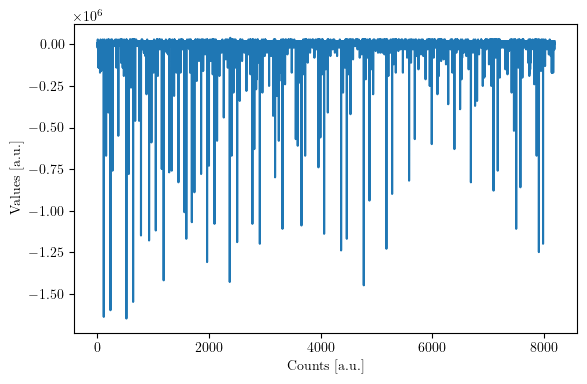

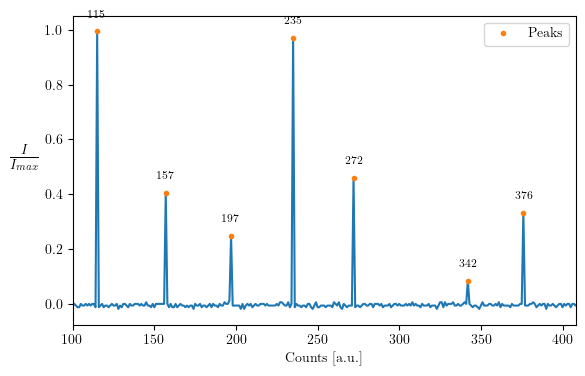

Average distance between peaks: 36.2
GHz per index: 0.027624309392265192


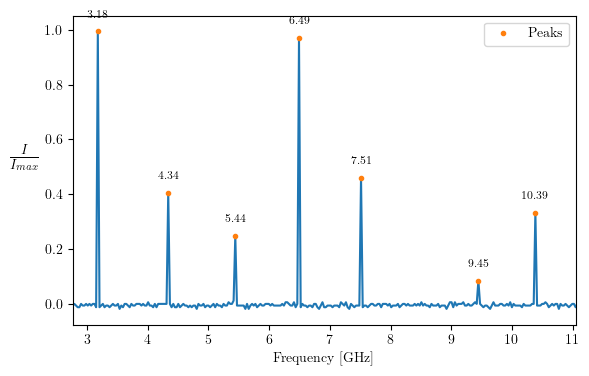

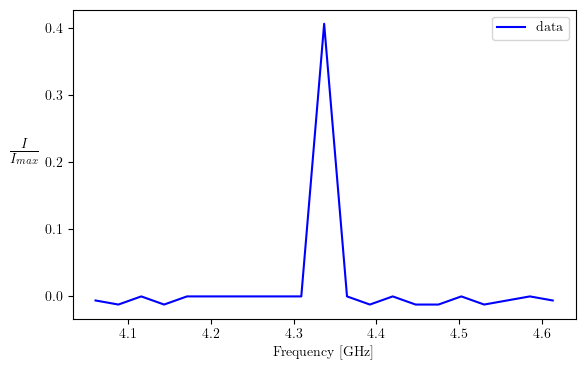

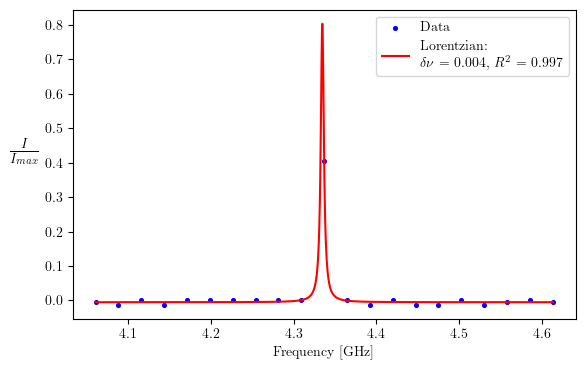

R^2= 0.996715437698836
dv 0.0044243402439455085
Finesse 226.02239992018036


In [211]:
#plot csv file
#import matplotlib as mpl
# Use the pgf backend (must be set before pyplot imported)
#mpl.use('pgf')
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })
plt.rcParams['font.size'] = 10


# Load the CSV file
data = pd.read_csv(r'Task 4\102mA\Broad.csv')

# Clean the column names by removing commas
data.columns = [col.replace(',', '') for col in data.columns]

# Convert the data to numeric values (removing commas in data)
data = data.replace({',': ''}, regex=True).apply(pd.to_numeric)

# Select the series with column name '20000'

series_data = data.iloc[:, 1]
limit = 600

# Plot the original series
plt.figure(figsize=set_size(469))
plt.plot(series_data)
plt.xlabel('Counts [a.u.]')
plt.ylabel('Values [a.u.]')
#plt.savefig(r'Latex\Figures\1\FPI_Data.pgf', format='pgf')
plt.show()

# Flip the data about the x-axis
flipped_series_data = -series_data

# Normalize the flipped data
normalized_flipped_series_data = (flipped_series_data) / (flipped_series_data.max())

# Find peaks in the flipped normalized series
peaks, _ = find_peaks(normalized_flipped_series_data, height = 0.03)

# Calculate distances between consecutive peaks
peak_distances = np.diff(peaks)

# Plot the flipped normalized series with peaks highlighted
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(normalized_flipped_series_data)
ax.plot(peaks, normalized_flipped_series_data[peaks], '.', label='Peaks')
ax.set_xlabel('Counts [a.u.]')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=14)


# Annotate the peaks
for peak in peaks:
    ax.annotate(peak, (peak, normalized_flipped_series_data[peak]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=0)

ax.legend()
ax.set_xlim(100, 408)
#plt.savefig(r'Latex\Figures\1\FPI_Peaks.pgf', format='pgf')
plt.show()

# Compute the average distance between peaks in the filtered array
average_peak_distance = np.mean(peak_distances)
GHz_per_index = 1/ average_peak_distance
print(f'Average distance between peaks: {average_peak_distance}')
print(f'GHz per index: {GHz_per_index}')

# Compute the x-values in GHz
x_values_GHz = np.arange(len(normalized_flipped_series_data)) * GHz_per_index

# Plot the flipped normalized series with peaks highlighted
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(x_values_GHz, normalized_flipped_series_data)
ax.plot(peaks * GHz_per_index, normalized_flipped_series_data[peaks], '.', label='Peaks')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=14)


# Annotate the peaks
for peak in peaks:
    ax.annotate(f'{peak * GHz_per_index:.2f}', (peak * GHz_per_index, normalized_flipped_series_data[peak]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=0)

ax.legend()
ax.set_xlim(100 * GHz_per_index, 400 * GHz_per_index)
#plt.savefig(r'Latex\Figures\1\FPI_Peaks_GHz.pgf', format='pgf')
plt.show()


# Define the Lorentzian function with an amplitude parameter
def lorentzian(x, x0, dv, C, y0):
    return  y0 + (2*C/np.pi)*(dv / (4*(x - x0)**2 + (dv)**2))

peak_index = peaks[6]
window_size = 10 # Adjust as needed
window_indices = range(max(0, peak_index - window_size), min(len(normalized_flipped_series_data), peak_index + window_size + 1))
window_x = x_values_GHz[window_indices]
window_y = normalized_flipped_series_data[window_indices]

# Initial parameter estimates
x0_initial = x_values_GHz[peak_index]  # center frequency of the peak
gamma_initial = 0.1  # width of the peak
C_initial = max(window_y)  # height of the peak
y0_initial = normalized_flipped_series_data.min()  # offset

# Now you can use A_initial in your initial parameter estimates
p0 = [x0_initial, gamma_initial, C_initial, y0_initial]

fit_options = {'maxfev': 10000}

# Fit the Lorentzian function to the data in the window
popt, _ = curve_fit(lorentzian, window_x, window_y, p0=p0)

# Calculate the R^2 score for the original fit
predicted_y = lorentzian(window_x, *popt)
r2 = r2_score(window_y, predicted_y)


# Plot the original data and the fitted function for the window only
fig, ax = plt.subplots(figsize=set_size(469))
ax.plot(window_x, window_y, 'b-', label='data')
#ax.plot(window_x, predicted_y, 'r-', label=r'fit: $\delta \nu$=%5.6f, $R^2$=%5.3f' % (popt[1], r2))
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=14)
ax.legend()
plt.show()

# Generate high-resolution x-values
high_res_x = np.linspace(window_x.min(), window_x.max(), 1000)

# Calculate the corresponding y-values using the fitted parameters
high_res_y = lorentzian(high_res_x, *popt)

# Plot the original data and the high-resolution fitted function
fig, ax = plt.subplots(figsize=set_size(469))
ax.scatter(window_x, window_y, c='b', label='Data', s=7)
ax.plot(high_res_x, high_res_y, 'r-', label=r'Lorentzian:' + '\n' + r'$\delta \nu$' + f' = {popt[1]:.3f}, ' + r'$R^2$' + f' = {r2:.3f}')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel(r'$\frac{I}{I_{max}}$', rotation='horizontal', labelpad=15, fontsize=14)

# Get handles and labels for legend
handles, labels = ax.get_legend_handles_labels()

# Create the legend
legend = ax.legend(handles, labels, loc='best', fancybox=True)

#plt.savefig(r'Latex\Figures\1\FPI_Fit.pgf', format='pgf')
plt.show()

print('R^2=', r2)
print('dv', popt[1])
print('Finesse', 1/popt[1])

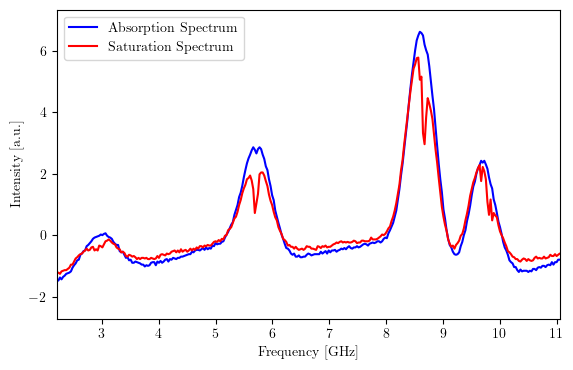

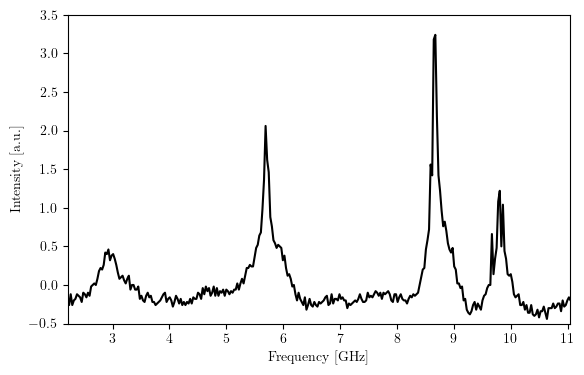

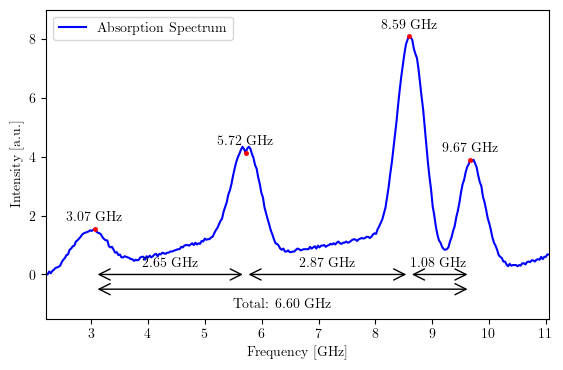

In [212]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
from matplotlib.patches import FancyArrowPatch


plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

# Load the CSV files
data1 = pd.read_csv(r'Task 4\102mA\Broad.csv')
data2 = pd.read_csv(r'Task 4\102mA\BroadBlocked.csv')

# Clean the column names by removing commas
data1.columns = [col.replace(',', '') for col in data1.columns]
data2.columns = [col.replace(',', '') for col in data2.columns]

# Convert the data to numeric values (removing commas in data)
data1 = data1.replace({',': ''}, regex=True).apply(pd.to_numeric)
data2 = data2.replace({',': ''}, regex=True).apply(pd.to_numeric)

# Select the series with column name '20000'
series_column1 = '-50000'
series_column2 = '-84000'
series_data1 = data1[series_column1]
series_data2 = data2[series_column2]
limit = 400

# Convert the index to GHz

series_data1.index = series_data1.index * GHz_per_index
series_data2.index = series_data2.index * GHz_per_index
series_data1 = series_data1/100000
series_data2 = series_data2/100000

# Plot the original series
plt.figure(figsize=set_size(469))
plt.plot(series_data2, label='Absorption Spectrum', color='blue')
plt.plot(series_data1, label='Saturation Spectrum', color='red')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Intensity [a.u.]')
#plt.title('FPI Data')
plt.xlim(80*GHz_per_index, limit*GHz_per_index)
plt.legend()
#plt.savefig(r'Latex\Figures\4\Absorption_Saturation.pgf', format='pgf')
plt.show()

# Plot the difference between then

plt.figure(figsize=set_size(469))
plt.plot(series_data2 - series_data1, color='black')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Intensity [a.u.]')
#plt.title('FPI Data')
plt.xlim(80*GHz_per_index, limit*GHz_per_index)
plt.ylim(-0.5, 3.5)
#plt.savefig(r'Latex\Figures\4\Absorption_Saturation_Difference.pgf', format='pgf')
plt.show()

# Define the x-limits
x_lower_limit = 80*GHz_per_index
x_upper_limit = limit*GHz_per_index

# Select the data within the x-limits
selected_data = series_data2[(series_data2.index >= x_lower_limit) & (series_data2.index <= x_upper_limit)]
selected_data = selected_data - selected_data.min()

# Find the peaks
peaks, _ = find_peaks(selected_data, distance=2, prominence=1)

# Shift the third peak
if len(peaks) >= 3:
    peaks[2] = (peaks[1] + peaks[2]) // 2

# Delete the second and last peak
if len(peaks) >= 3:
    peaks = np.delete(peaks, [1, -1])

# Calculate the distances between the peaks
peak_distances = np.diff(peaks)

# Plot the selected data
plt.figure(figsize=set_size(469))
plt.plot(selected_data.index, selected_data, label='Absorption Spectrum', color='blue')

# Plot the peaks
for i in range(len(peaks) ):
    #if i != 1:  # Skip the second peak
        plt.plot(selected_data.index[peaks[i]], selected_data.iloc[peaks[i]], ".", markersize=5, color='red')

# Annotate the distances between the peaks
for i in range(len(peaks)):
    if i + 1 < len(peaks) and peak_distances[i] > 10:
        plt.annotate(f'{peak_distances[i] * GHz_per_index:.2f} GHz', 
                     ((selected_data.index[peaks[i]] + selected_data.index[peaks[i + 1]]) / 2, 0), 
                     textcoords="offset points", xytext=(0, 5), ha='center')
        arrow = FancyArrowPatch((selected_data.index[peaks[i]], 0), (selected_data.index[peaks[i + 1]], 0), 
                                arrowstyle='<->', mutation_scale=20)
        plt.gca().add_patch(arrow)
    plt.annotate(f'{selected_data.index[peaks[i]]:.2f} GHz', 
                 (selected_data.index[peaks[i]], selected_data.iloc[peaks[i]]), 
                 textcoords="offset points", xytext=(0, 5), ha='center')

# Calculate total distance between first and last peak
total_distance = selected_data.index[peaks[-1]] - selected_data.index[peaks[0]]

# Annotate the total distance
plt.annotate(f'Total: {total_distance:.2f} GHz', 
             ((selected_data.index[peaks[0]] + selected_data.index[peaks[-1]]) / 2, 0), 
             textcoords="offset points", xytext=(0, -25), ha='center')

# Add an arrow for total distance
total_distance_arrow = FancyArrowPatch((selected_data.index[peaks[0]], -0.5), (selected_data.index[peaks[-1]], -0.5), 
                                       arrowstyle='<->', mutation_scale=20)
plt.gca().add_patch(total_distance_arrow)

plt.xlabel('Frequency [GHz]')
plt.ylabel('Intensity [a.u.]')
plt.xlim(selected_data.index[0], selected_data.index[-1])
plt.ylim(-1.5, 9)

plt.legend()
#plt.savefig(r'Latex\Figures\4\Absorption_Spectrum_Peaks.pgf', format='pgf')
plt.show()


Peak 1:
  R^2 = 0.9805691453669935
  Gamma = 3.2254728759055944e-16
  Sigma = 0.24355282781395426
  FWHM = 0.5735230809602715


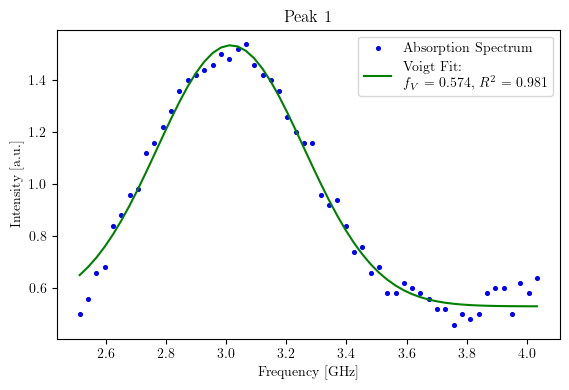

Peak 2:
  R^2 = 0.9906438199183543
  Gamma = 1.50068515309386e-14
  Sigma = 0.2553796871594955
  FWHM = 0.601373206416945


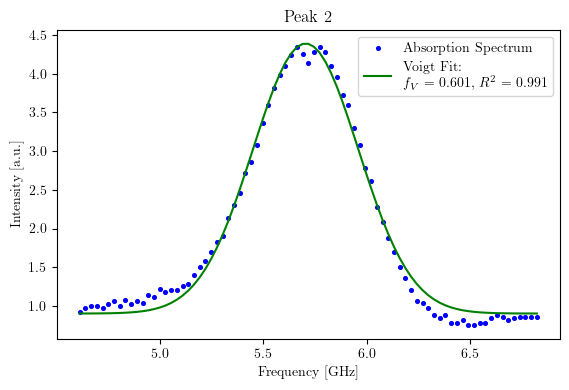

Peak 3:
  R^2 = 0.9968915822503005
  Gamma = 9.370675176559011e-16
  Sigma = 0.22603082016623766
  FWHM = 0.5322619061222441


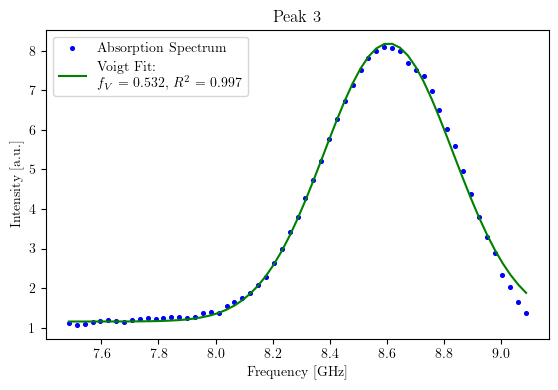

Peak 4:
  R^2 = 0.9990199238225799
  Gamma = 0.05754804984177876
  Sigma = 0.19797826320461046
  FWHM = 0.5923311750487152


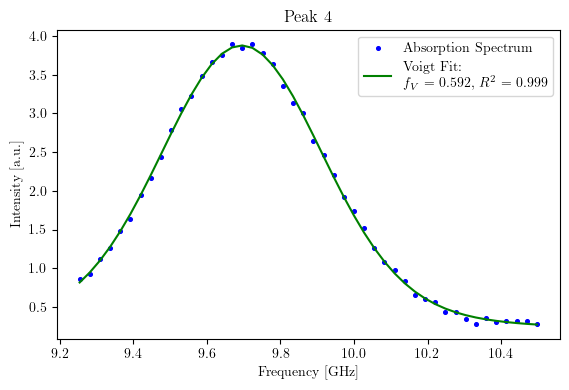

In [213]:
import numpy as np
from scipy.special import voigt_profile
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 10

def custom_voigt(x, amp, cen, sigma, gamma, y_offset):
    return amp * voigt_profile(x - cen, sigma, gamma) + y_offset

# Assuming peaks is a list or array containing peak indices
for i, peak_index in enumerate(peaks):
    if peak_index < 0 or peak_index >= len(selected_data):
        print(f"Peak {i + 1} at index {peak_index} is out of bounds.")
        continue
    
    # Define window size for fitting around the peak
    if i == 0:
        lower_window_size = 20
        upper_window_size = 35
    elif i == 2:
        lower_window_size = 40
        upper_window_size = 18
    elif i == 3:
        lower_window_size = 15
        upper_window_size = 30
    else:
        lower_window_size = 40
        upper_window_size = 40

    # Define the window limits
    lower_limit = max(0, peak_index - lower_window_size)
    upper_limit = min(len(selected_data) - 1, peak_index + upper_window_size)

    # Select the data within the window
    window_data = selected_data.iloc[lower_limit:upper_limit + 1]
    window_index = window_data.index.values

    # Improved initial guesses for fitting parameters
    amp_init = window_data.max() - window_data.min()
    cen_init = window_index[window_data.argmax()]
    sigma_init = (window_index[-1] - window_index[0]) / 4  # Rough guess based on window width
    gamma_init = sigma_init / 2  # Adjusted initial guess for gamma
    y_offset_init = window_data.min()

    p0 = [amp_init, cen_init, sigma_init, gamma_init, y_offset_init]

    # Add bounds for positive parameters (sigma, gamma)
    bounds = ([0, -np.inf, 0, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf])

    try:
        # Fit the custom Voigt function to the data
        popt, pcov = curve_fit(custom_voigt, window_index, window_data, p0=p0, maxfev=50000, bounds=bounds)
        
        # Calculate the R-squared value
        y_pred = custom_voigt(window_index, *popt)
        r_squared = r2_score(window_data, y_pred)

        # Extract the parameters
        amp, cen, sigma, gamma, y_offset = popt

        # Calculate FWHM
        w_G = 2 * np.sqrt(2 * np.log(2)) * sigma
        w_L = 2 * gamma
        w_V = 0.5346 * 2 * w_L + np.sqrt(0.2166 * w_L**2 + w_G**2)

        print(f"Peak {i + 1}:")
        print(f"  R^2 = {r_squared}")
        print(f"  Gamma = {gamma}")
        print(f"  Sigma = {sigma}")
        print(f"  FWHM = {w_V}")

        # Plot the window data and the fit
        plt.figure(figsize=set_size(469))  # Adjust the figure size as needed
        plt.scatter(window_index, window_data, label='Absorption Spectrum', color='blue', s=7)
        plt.plot(window_index, custom_voigt(window_index, *popt), label=f'Voigt Fit:\n$f_V$ = {w_V:.3f}, $R^2$ = {r_squared:.3f}', color='green')

        plt.xlabel('Frequency [GHz]')
        plt.ylabel('Intensity [a.u.]')
        plt.title(f'Peak {i + 1}')

        handles, labels = plt.gca().get_legend_handles_labels()
        legend = plt.legend(handles, labels, loc='best', fancybox=True)
       
        #plt.savefig(f'Latex/Figures/4/VoigtFit_{i + 1}.pgf', format='pgf')
        plt.show()
        

    except RuntimeError as e:
        print(f"Fitting failed for peak {i + 1} at index {peak_index}: {e}")


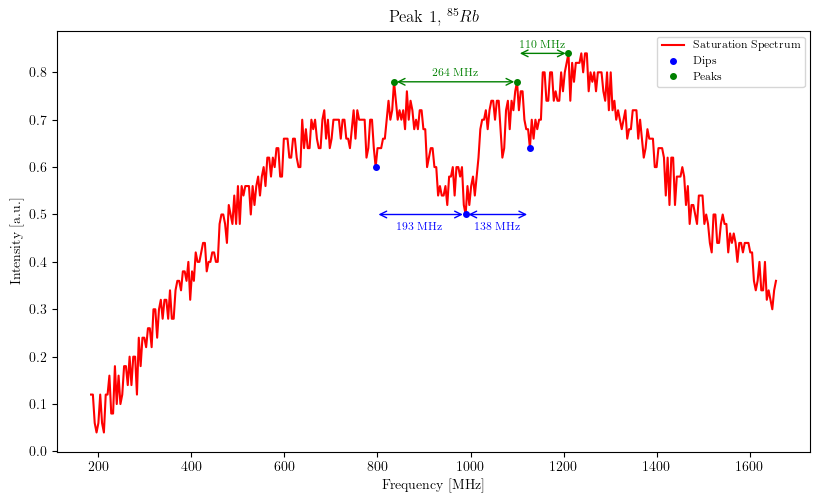

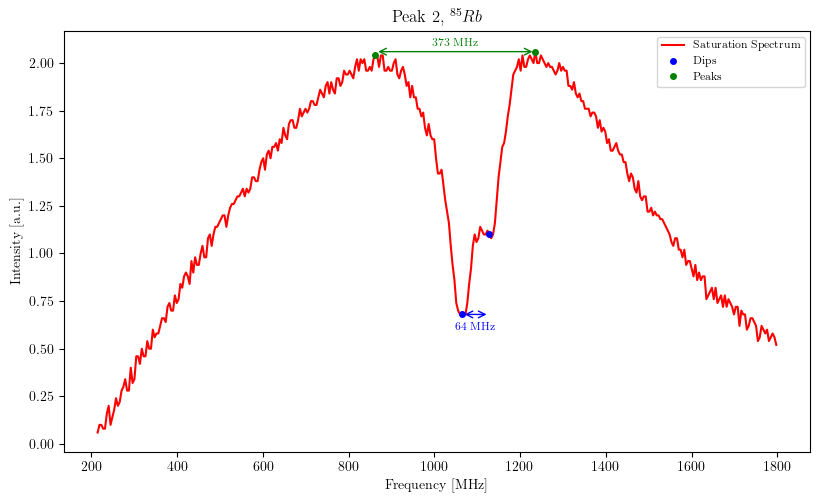

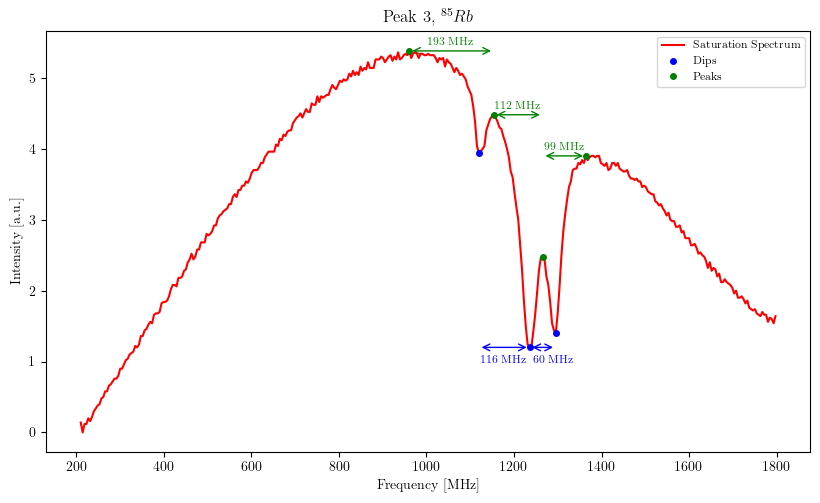

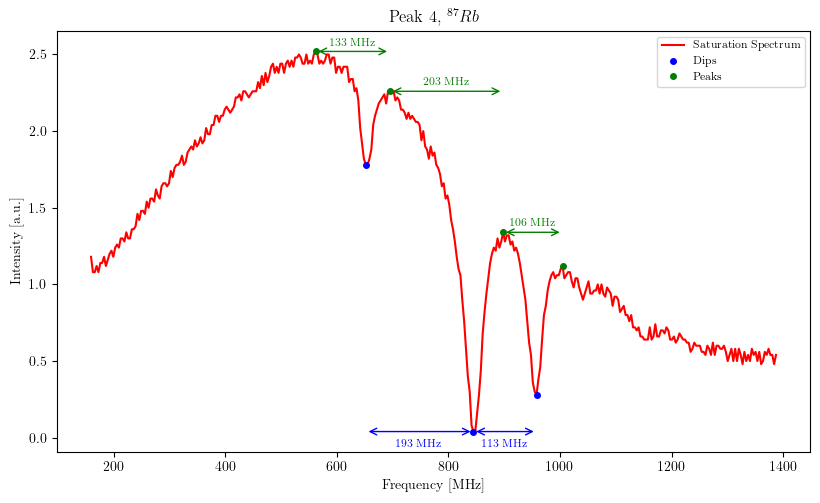

In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.signal import find_peaks

# Define a dictionary with peak numbers as keys and (lower_window_size, upper_window_size) as values
window_sizes = {
    1: (260, 114),
    2: (-15, 385),
    3: (-18, 389),
    4: (-20, 390),
}

GHz_per_index = [0.003941372090158887, 0.004289679535705274, 0.004289679535705274, 0.0033255327010715606]  # Example value, adjust as necessary

# Function to set figure size based on column width
def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in LaTeX.

    Parameters:
    - width: Width in pts
    - fraction: Fraction of the width which you wish the figure to occupy

    Returns:
    - fig_dim: Dimensions of figure in inches
    """
    fig_width_pt = width * fraction
    inches_per_pt = 1 / 72.27  # Convert from pt to inches
    golden_ratio = (5**0.5 - 1) / 2  # Aesthetic ratio (you could change this)
    fig_width_in = fig_width_pt * inches_per_pt  # Width of figure in inches
    fig_height_in = fig_width_in * golden_ratio  # Height of figure in inches
    fig_dim = (fig_width_in, fig_height_in)  # Final dimensions of figure in inches
    return fig_dim

# Plotting loop
for i in range(1, 5):
    file_path = f'Task 4\\102mA\\Peak{i}.csv'
    data = pd.read_csv(file_path)

    # Clean the column names and convert data to numeric values
    data.columns = [col.replace(',', '') for col in data.columns]
    data = data.replace({',': ''}, regex=True).apply(pd.to_numeric)

    # Process the first column of the data
    series_data = data.iloc[:, 0] / 100000
    series_data -= series_data.min()

    # Find peaks
    peaks, _ = find_peaks(series_data, height=0, prominence=0.5)
    if len(peaks) == 0:
        continue

    first_peak = peaks[1]  # Assuming you want to use the second detected peak

    # Retrieve the specific window sizes for the current peak
    lower_window_size, upper_window_size = window_sizes[i]

    # Extract the window of data around the peak
    window_start = max(first_peak - lower_window_size, 0)
    window_end = min(first_peak + upper_window_size, len(series_data))
    window_index = np.arange(window_start, window_end)
    window_data = series_data.iloc[window_start:window_end].to_numpy()

    # Convert window_index to MHz
    window_index_MHz = window_index * GHz_per_index[i-1] * 1000

    # Find dips within the window
    dips, _ = find_peaks(-window_data, prominence=0.12)  # Find minima by inverting the data

    # Find peaks within the window
    peaks_in_window, _ = find_peaks(window_data, prominence=0.13)  # Find maxima

    # Manual adjustments for dips
    if i == 2:
        # Add a dip at 1.13 GHz for peak 2
        target_freq = 1.13 * 1000
        closest_index = np.argmin(np.abs(window_index_MHz - target_freq))
        dips = np.append(dips, closest_index)
        dips = np.sort(dips)  # Ensure the dips are in sorted order
    elif i == 3:
        # Remove the first dip for peak 3
        if len(dips) > 0:
            dips = dips[1:]

    # Additional manual adjustments for peaks and dips
    if i == 1:
        # Remove the last two peaks for peak 1
        if len(peaks_in_window) >= 2:
            peaks_in_window = peaks_in_window[:-2]
    elif i == 2:
        # Remove the second peak for peak 2
        if len(peaks_in_window) >= 2:
            peaks_in_window = np.delete(peaks_in_window, 1)
    elif i == 3:
        # Remove the last two peaks for peak 3
        if len(peaks_in_window) >= 2:
            peaks_in_window = peaks_in_window[:-2]
    elif i == 4:
        # Remove the last dip for peak 4
        if len(dips) >= 1:
            dips = dips[:-1]

    # Calculate distances between peaks and dips
    peak_distances = np.diff(window_index_MHz[peaks_in_window])
    dip_distances = np.diff(window_index_MHz[dips])

    # Plotting
    plt.figure(figsize=set_size(600))  # Adjust width as necessary

    # Plot with respect to different y-scales
    plt.plot(window_index_MHz, window_data, label='Saturation Spectrum', color='r')
    plt.plot(window_index_MHz[dips], window_data[dips], 'bo', label='Dips', markersize=4)
    plt.plot(window_index_MHz[peaks_in_window], window_data[peaks_in_window], 'go', label='Peaks', markersize=4)

    # Annotate peak distances
    for j in range(len(peak_distances)):
        x1 = window_index_MHz[peaks_in_window[j]]
        x2 = window_index_MHz[peaks_in_window[j + 1]]
        y = max(window_data[peaks_in_window[j]], window_data[peaks_in_window[j + 1]])  # Use max value for y-coordinate
        arrow = FancyArrowPatch((x1, y), (x2, y), arrowstyle='<->', color='green', mutation_scale=12)
        plt.gca().add_patch(arrow)
        y_range = window_data.max() - window_data.min()
        text_y_offset = 0.01 * y_range
        # Adjust text position to avoid overlap for peaks
        plt.text((x1 + x2) / 2, y +text_y_offset, f'{peak_distances[j]:.0f} MHz', ha='center', va='bottom', color='green', fontsize=8)

    # Annotate dip distances
    for j in range(len(dip_distances)):
        x1 = window_index_MHz[dips[j]]
        x2 = window_index_MHz[dips[j + 1]]
        y_min = min(window_data[dips[j]], window_data[dips[j + 1]])  # Use min value for y-coordinate
    
        # Calculate dynamic offset based on y-range
        y_range = window_data.max() - window_data.min()
        text_y_offset = -0.02 * y_range  # Adjust this factor as needed
    
        arrow = FancyArrowPatch((x1, y_min), (x2, y_min), arrowstyle='<->', color='blue', mutation_scale=12)
        plt.gca().add_patch(arrow)
    
        # Adjust annotation positions for peak 3
        if i == 3 and j == 1:
            shift = 25  
            x1 += shift
            x2 += shift
        
    
        plt.text((x1 + x2) / 2, y_min + text_y_offset, f'{dip_distances[j]:.0f} MHz', ha='center', va='top', color='blue', fontsize=8)
    plt.xlabel('Frequency [MHz]', fontsize=10)
    plt.ylabel('Intensity [a.u.]', fontsize=10)
    
    if i == 4:
        plt.title(f'Peak {i}, ' + r'$^{87}Rb$', fontsize=12)
    else:
        plt.title(f'Peak {i}, '+ r'$^{85}Rb$', fontsize=12)

    plt.legend(fontsize=8)
    plt.tight_layout()  # Improve spacing  
    plt.show()


Peak 1: Average distance between peaks: 41.34517766497462, GHz per index: 0.0241866175567833


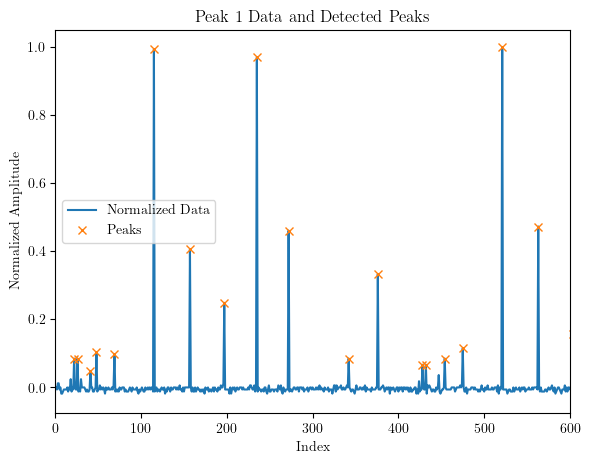

Peak 2: Average distance between peaks: 41.34517766497462, GHz per index: 0.0241866175567833


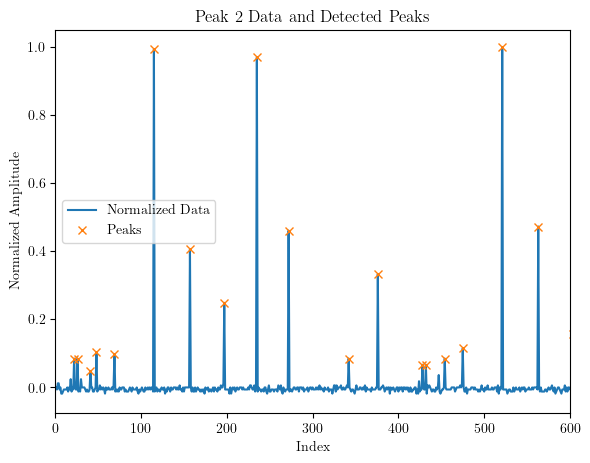

Peak 3: Average distance between peaks: 41.34517766497462, GHz per index: 0.0241866175567833


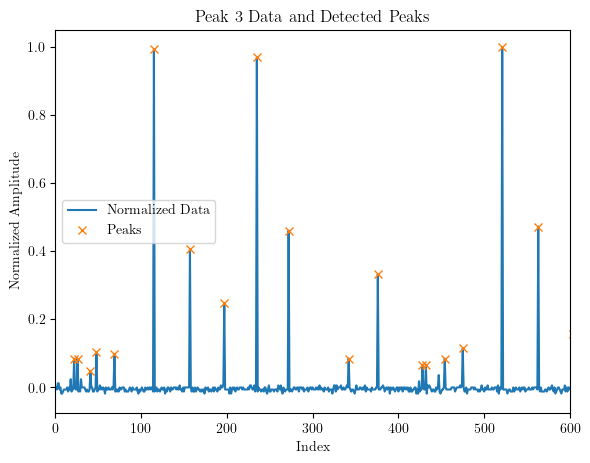

Peak 4: Average distance between peaks: 41.34517766497462, GHz per index: 0.0241866175567833


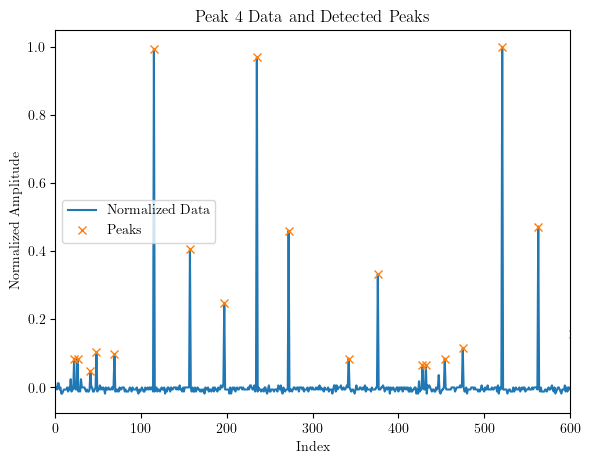

In [215]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def set_size(width, fraction=1):
    # Assuming the width is in points
    fig_width_pt = width * fraction
    inches_per_pt = 1 / 72.27
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * (3/4)  # Golden ratio
    return (fig_width_in, fig_height_in)

for i in range(1, 5):
    file_path = f'Task 4\\102mA\\Broad.csv'
    data = pd.read_csv(file_path)

    # Clean and convert data
    data.columns = [col.replace(',', '') for col in data.columns]
    data = data.replace({',': ''}, regex=True).apply(pd.to_numeric)

    series_data = data.iloc[:, 1]
    flipped_series_data = -series_data
    normalized_flipped_series_data = flipped_series_data / flipped_series_data.max()

    peaks, _ = find_peaks(normalized_flipped_series_data, height=0.04, prominence=0)
    peak_distances = np.diff(peaks)

    if len(peak_distances) > 0:
        average_peak_distance = np.mean(peak_distances)
        GHz_per_index = 1 / average_peak_distance
        print(f'Peak {i}: Average distance between peaks: {average_peak_distance}, GHz per index: {GHz_per_index}')
    else:
        print(f'Peak {i}: No peaks found')

    # Plotting
    plt.figure(figsize=set_size(480))
    plt.plot(normalized_flipped_series_data, label='Normalized Data')
    plt.plot(peaks, normalized_flipped_series_data[peaks], "x", label='Peaks')
    plt.title(f'Peak {i} Data and Detected Peaks')
    plt.xlabel('Index')
    plt.ylabel('Normalized Amplitude')
    plt.xlim(0, 600)
    plt.legend()
    plt.show()